In [1]:
from keras.utils import normalize
from keras.utils import to_categorical
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from unet import unet_model
from multi_class_unet import multiclass_unet_model
import random
from pathlib import Path
import logging
import itertools

LOGGER = logging.getLogger()
from datetime import datetime

from skimage.morphology import binary_erosion
from skimage.morphology import skeletonize
from skimage.filters import hessian
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

# TopoStats needs to be >= version 2.1.0
from topostats import io
from topostats import grain_finding_cats_unet

import tensorflow as tf
from sklearn.model_selection import train_test_split

for key, value in os.environ.items():
    print(f"{key} : {value}")

2023-09-01 16:26:03.822760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CHROME_DESKTOP : code-url-handler.desktop
DBUS_SESSION_BUS_ADDRESS : unix:path=/run/user/1000/bus
DEFAULTS_PATH : /usr/share/gconf/pop.default.path
DESKTOP_SESSION : pop
DISPLAY : :1
ELECTRON_NO_ATTACH_CONSOLE : 1
GDK_BACKEND : x11
GDMSESSION : pop
GIO_LAUNCHED_DESKTOP_FILE : /usr/share/applications/gitkraken.desktop
GIO_LAUNCHED_DESKTOP_FILE_PID : 6333
GJS_DEBUG_OUTPUT : stderr
GJS_DEBUG_TOPICS : JS ERROR;JS LOG
GNOME_DESKTOP_SESSION_ID : this-is-deprecated
GNOME_SHELL_SESSION_MODE : pop
GPG_AGENT_INFO : /run/user/1000/gnupg/S.gpg-agent:0:1
GTK_IM_MODULE : ibus
GTK_MODULES : gail:atk-bridge
HOME : /home/sylvia
INVOCATION_ID : a52202f8df3846cfb82744400669cf5b
JOURNAL_STREAM : 8:39328
LANG : en_US.UTF-8
LOGNAME : sylvia
MANAGERPID : 2577
MANDATORY_PATH : /usr/share/gconf/pop.mandatory.path
ORIGINAL_XDG_CURRENT_DESKTOP : Unity
PATH : /home/sylvia/anaconda3/envs/car-or-truck-p9/bin:/home/sylvia/anaconda3/condabin:/home/sylvia/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/s

In [2]:
# Ensure that your GPU is working
tf.test.gpu_device_name()

2023-09-01 16:26:12.955754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 16:26:12.975736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 16:26:13.022362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-01 16:26:13.022512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

'/device:GPU:0'

In [3]:
# Set the random seeds
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# IMAGE_DIR = Path('/home/sylvia/Desktop/dl_data/images/')
# MASK_DIR = Path('/home/sylvia/Desktop/dl_data/ground_truth/')
# MODEL_SAVE_DIR = Path('/home/sylvia/Desktop/dl_data/saved_models/')
# IMAGE_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_training_sigma_4/")
# ORIGINAL_IMAGE_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_flattened_all/")
# MASK_DIR = Path("/Users/sylvi/topo_data/cats/training_data/ground_truth_edges/")
# MASK_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_labels_sigma_4/")
# MASK_DIR = Path("/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_labels_multiclass_sigma_4/")

# Linux
IMAGE_DIR = Path("/home/sylvia/cats_data/images_edge_detection_upper_training_sigma_4")
ORIGINAL_IMAGE_DIR = Path("/home/sylvia/cats_data/images_flattened_all/")
MASK_DIR = Path("/home/sylvia/cats_data/images_edge_detection_upper_labels_multiclass_sigma_4/")

MODEL_SAVE_DIR = Path("./catsnet/saved_models/")
SIZE = 1024
CHANNELS = 2

In [5]:
def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order="rc")
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return minima_ridges

In [6]:
def pad_2d_array(array: np.ndarray, shape: tuple) -> np.ndarray:
    pad_width = ((0, shape[0] - array.shape[0]), (0, shape[1] - array.shape[1]))
    padded_array = np.pad(array, pad_width, mode="constant", constant_values=0)
    return padded_array


def pad_arrays(arrays: list, shape: tuple) -> list:
    padded_arrays = []
    for array in arrays:
        padded_array = pad_2d_array(array, shape)
        padded_arrays.append(padded_array)
    return padded_arrays

In [7]:
original_image_dataset = []
image_dataset = []
mask_dataset = []

print(" -- images --")


original_images = ORIGINAL_IMAGE_DIR.glob("*.png")
original_images = sorted(original_images, key=lambda p: p.name)
print(original_images)
for index, image_name in enumerate(original_images):
    print(image_name)
    image = cv2.imread(str(ORIGINAL_IMAGE_DIR / image_name), 0)
    # image = Image.fromarray(image)
    # image = image.resize((SIZE, SIZE))
    image = np.array(image)
    # Nomalise
    image = image - np.min(image)
    image = image / np.max(image)
    original_image_dataset.append(image)

images = os.listdir(IMAGE_DIR)
images = sorted(images)
print(images)
for index, image_name in enumerate(images):
    print(image_name)
    if image_name.split(".")[-1] == "png":
        image = cv2.imread(str(IMAGE_DIR / image_name), 0)
        # image = Image.fromarray(image)
        # image = image.resize((SIZE, SIZE))
        image = np.array(image)
        # Normalise
        image = image - np.min(image)
        image = image / np.max(image)
        image_dataset.append(image)

print("-- masks --")

mask_files = list(MASK_DIR.glob("*.npy"))
mask_files = sorted(mask_files, key=lambda p: p.name)
print(mask_files)
for index, mask_file in enumerate(mask_files):
    print(mask_file.name)
    # image = cv2.imread(str(MASK_DIR / image_name), 0)
    image = np.load(mask_file)
    # image = Image.fromarray(image.astype(np.uint8))
    # image = image.resize((SIZE, SIZE))
    image = np.array(image)
    mask_dataset.append(image.astype(int))

# Find the maximum size
max_shape = max(array.shape for array in image_dataset)
print(f"maximum numpy image array size: {max_shape}")
# Pad all numpy arrays with 0s to match the maximum shape
original_image_dataset = pad_arrays(original_image_dataset, shape=max_shape)
image_dataset = pad_arrays(image_dataset, shape=max_shape)
mask_dataset = pad_arrays(mask_dataset, shape=max_shape)

print(f"min dataset shapes:")
print(min(array.shape for array in original_image_dataset))
print(min(array.shape for array in image_dataset))
print(min(array.shape for array in mask_dataset))

 -- images --
[PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_0.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_1.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_10.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_11.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_12.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_13.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_14.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_15.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_16.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_17.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_18.png'), PosixPath('/home/sylvia/cats_data/images_flattened_all/training_image_19.png'), PosixPath('/home/sylvia/cat

image dataset size: 44
mask dataset size: 44
index: 0


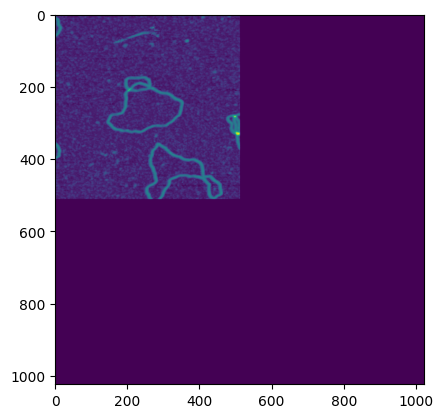

original image dataset | min: 0.0 max: 1.0
(1024, 1024)


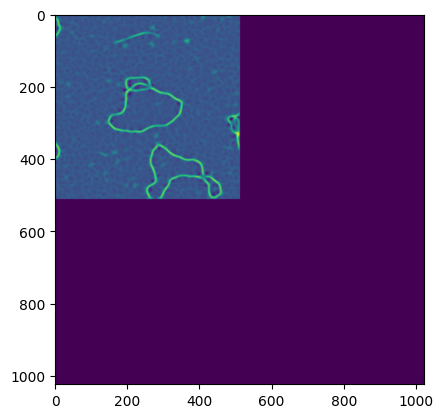

img dataset | min: 0.0 max: 1.0
(1024, 1024)


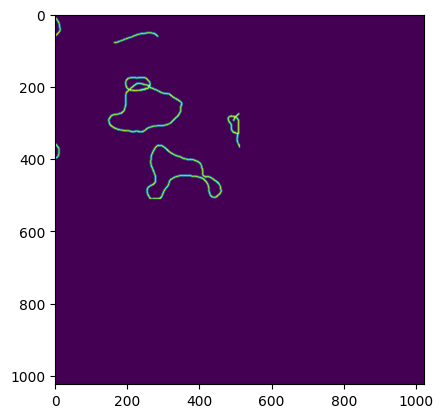

unique: [0 1 2]
shape: (1024, 1024)


In [8]:
# Check the data has been loaded correctly

print(f"image dataset size: {len(image_dataset)}")
print(f"mask dataset size: {len(mask_dataset)}")

index = np.random.randint(0, len(image_dataset) - 1)
print(f"index: {index}")

plt.imshow(original_image_dataset[index])
plt.show()
print(f"original image dataset | min: {np.min(original_image_dataset)} max: {np.max(original_image_dataset)}")
print(np.shape(original_image_dataset[index]))

plt.imshow(image_dataset[index])
plt.show()
print(f"img dataset | min: {np.min(image_dataset)} max: {np.max(image_dataset)}")
print(np.shape(image_dataset[index]))

plt.imshow(mask_dataset[index])
plt.show()
print(f"unique: {np.unique(mask_dataset[index])}")
print(f"shape: {np.shape(mask_dataset[index])}")

In [9]:
# Convert from integer based classes to one-hot encoding
mask_dataset = np.array(mask_dataset)
print(mask_dataset.shape)
mask_dataset = to_categorical(mask_dataset, 3)
print(mask_dataset.shape)

(44, 1024, 1024)
(44, 1024, 1024, 3)


In [10]:
# DO NOT RUN MORE THAN ONCE

# Expand dims because the model doesn't work unless we add an extra dimension, don't know why.
original_image_dataset = np.expand_dims(np.array(original_image_dataset), 3)
image_dataset = np.expand_dims(np.array(image_dataset), 3)
# mask_dataset = np.expand_dims(np.array(mask_dataset), 3)

print(image_dataset.shape)
print(mask_dataset.shape)
print(f"image dataset min, max: {np.min(image_dataset), np.max(image_dataset)}")
print(f"mask unique values: {np.unique(mask_dataset)}")

(44, 1024, 1024, 1)
(44, 1024, 1024, 3)
image dataset min, max: (0.0, 1.0)
mask unique values: [0. 1.]


In [11]:
del mask_file, max_shape, images, image_name, image, original_images, mask_files, index

In [12]:
# Combine original image dataset and ridges image dataset for training
image_dataset = np.append(image_dataset, original_image_dataset, axis=3)

(44, 1024, 1024, 2)


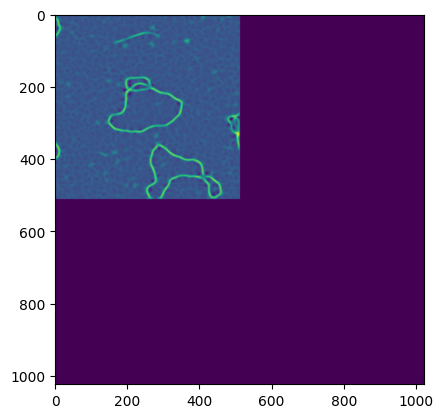

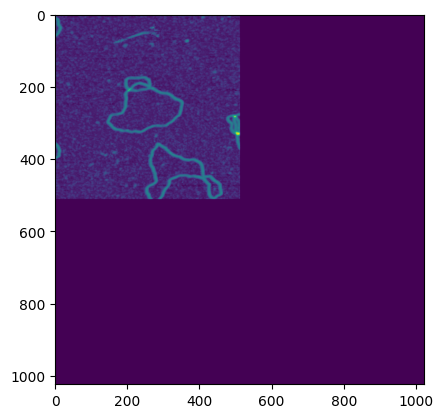

In [13]:
print(image_dataset.shape)
plt.imshow(image_dataset[0, :, :, 0])
plt.show()
plt.imshow(image_dataset[0, :, :, 1])
plt.show()

In [14]:
del original_image_dataset

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=SEED)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

del image_dataset, mask_dataset

(39, 1024, 1024, 2)
(5, 1024, 1024, 2)
(39, 1024, 1024, 3)
(5, 1024, 1024, 3)


In [15]:
def rotate_image(image: np.ndarray, angle_90_multiple: int):
    return np.rot90(image, k=angle_90_multiple)


def flip_image(image: np.ndarray):
    return np.flipud(image)


def augment_image(image: np.ndarray):
    images = []

    return images


def augment_image_set(training_set: np.ndarray):
    augmented_set = np.zeros(
        (training_set.shape[0] * 8, training_set.shape[1], training_set.shape[2], training_set.shape[3])
    )

    for layer_index in range(training_set.shape[3]):
        for index in range(training_set.shape[0]):
            image = training_set[index, :, :, layer_index]
            image_flipped = flip_image(image)
            augmented_set[index * 8 + 0, :, :, layer_index] = image
            augmented_set[index * 8 + 1, :, :, layer_index] = image_flipped.copy()
            augmented_set[index * 8 + 2, :, :, layer_index] = rotate_image(image_flipped.copy(), 1)
            augmented_set[index * 8 + 3, :, :, layer_index] = rotate_image(image_flipped.copy(), 2)
            augmented_set[index * 8 + 4, :, :, layer_index] = rotate_image(image_flipped.copy(), 3)

            augmented_set[index * 8 + 5, :, :, layer_index] = rotate_image(image.copy(), 1)
            augmented_set[index * 8 + 6, :, :, layer_index] = rotate_image(image.copy(), 2)
            augmented_set[index * 8 + 7, :, :, layer_index] = rotate_image(image.copy(), 3)

    return augmented_set

In [16]:
print(X_train.shape)
print(y_train.shape)

X_train = augment_image_set(X_train)
y_train = augment_image_set(y_train)

print(X_train.shape)
print(y_train.shape)

(39, 1024, 1024, 2)
(39, 1024, 1024, 3)
(312, 1024, 1024, 2)
(312, 1024, 1024, 3)


In [ ]:
print(np.max(X_train))
print(np.min(X_train))
print(np.unique(y_train))

In [17]:
memory_size = X_train.size * X_train.itemsize + y_train.size * y_train.itemsize + X_test.size * X_test.itemsize + y_test.size * y_test.itemsize
print(f"memory size of training dataset: {(memory_size) / (1e9):.2f}GB {X_train.dtype}")

memory size of training dataset: 13.23GB float64


image number: 43 / 312


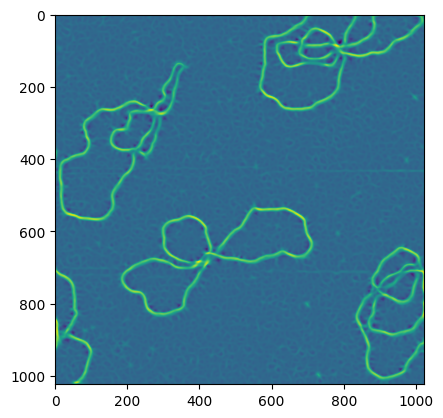

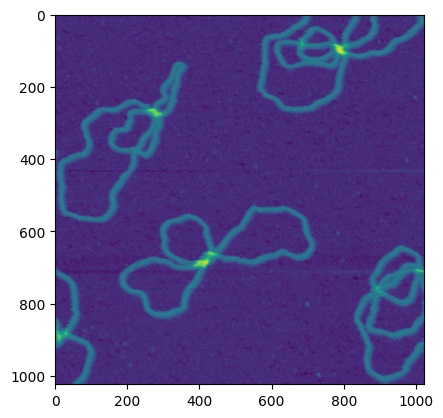

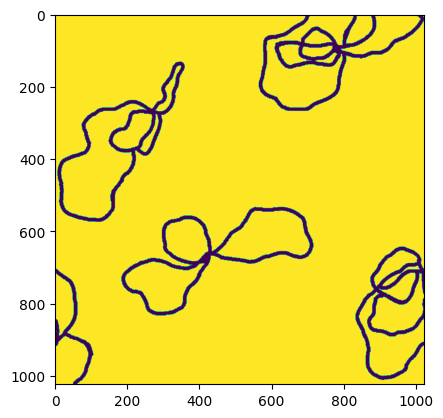

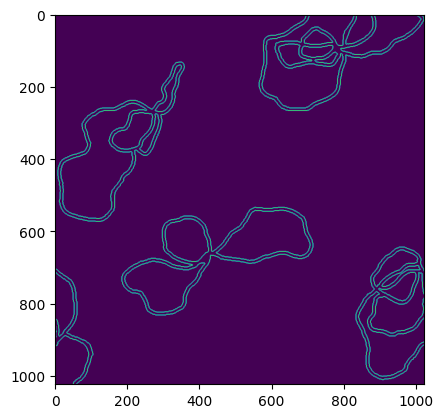

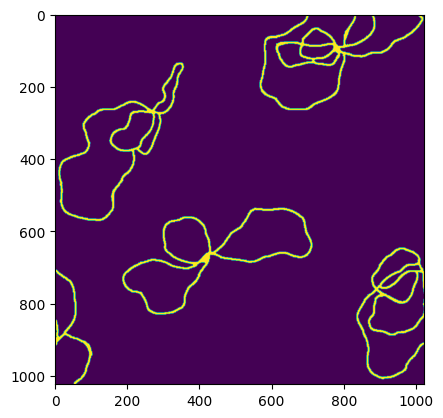

In [18]:
# Check things are working correctly
image_number = random.randint(0, len(X_train) - 1)
print(f"image number: {image_number} / {len(X_train)}")
plt.imshow(X_train[image_number, :, :, 0])
plt.show()
plt.imshow(X_train[image_number, :, :, 1])
plt.show()
plt.imshow(y_train[image_number, :, :, 0])
plt.show()
plt.imshow(y_train[image_number, :, :, 1])
plt.show()
plt.imshow(y_train[image_number, :, :, 2])
plt.show()
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap="gray")
# plt.subplot(122)
# plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap="gray")
# plt.show()

In [21]:
IMG_HEIGHT = SIZE
IMG_WIDTH = SIZE
IMG_CHANNELS = IMG_CHANNELS


def get_model():
    return multiclass_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)


model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 2)]                                                              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 1024, 1024,   304         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 dropout_9 (Dropout)            (None, 1024, 1024,   0           ['conv2d_19[0][0]']              
                                16)                                                         

In [23]:
# Train the model
BATCH_SIZE = 4
EPOCHS = 50
history = model.fit(
    X_train, y_train, batch_size=4, verbose=1, epochs=50, validation_data=(X_test, y_test), shuffle=False
)

# SAVE THE MODEL WITH DATE AND PARAMS IN THE NAME
now = datetime.now()
dt_string = str(now.strftime("%Y%m%d_%H-%M-%S"))
filename = str(MODEL_SAVE_DIR / f"{dt_string}_cats_{SIZE}_b{BATCH_SIZE}_e{EPOCHS}_hessian_upper_4_0_multiclass.hdf5")
print(f"saving file: {filename}")
model.save(filename)

2023-09-01 15:46:28.351728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2617245696 exceeds 10% of free system memory.


Epoch 1/50


2023-09-01 15:47:13.368767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-09-01 15:47:14.199923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-09-01 15:47:15.979397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-01 15:47:16.181614: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ef8a374ca00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-01 15:47:16.181632: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-09-01 15:47:16.227198: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util

78/78 [==============================] - 28s 226ms/step - loss: 0.3608 - accuracy: 0.9667 - val_loss: 0.0641 - val_accuracy: 0.9759
Epoch 2/50
78/78 [==============================] - 16s 209ms/step - loss: 0.0961 - accuracy: 0.9687 - val_loss: 0.0758 - val_accuracy: 0.9783
Epoch 3/50
78/78 [==============================] - 16s 208ms/step - loss: 0.0909 - accuracy: 0.9685 - val_loss: 0.0618 - val_accuracy: 0.9824
Epoch 4/50
78/78 [==============================] - 16s 206ms/step - loss: 0.0792 - accuracy: 0.9744 - val_loss: 0.0524 - val_accuracy: 0.9801
Epoch 5/50
78/78 [==============================] - 16s 208ms/step - loss: 0.0570 - accuracy: 0.9797 - val_loss: 0.0459 - val_accuracy: 0.9806
Epoch 6/50
78/78 [==============================] - 16s 206ms/step - loss: 0.0526 - accuracy: 0.9810 - val_loss: 0.0442 - val_accuracy: 0.9811
Epoch 7/50
78/78 [==============================] - 16s 209ms/step - loss: 0.0493 - accuracy: 0.9819 - val_loss: 0.0426 - val_accuracy: 0.9820
Epoch 8/50

## Load model

In [ ]:
# # LOAD MODEL
# model = tf.keras.models.load_model(MODEL_SAVE_DIR / "20230811_14-26-19_cats.hdf5")
path_to_model = MODEL_SAVE_DIR / "20230830_14-46-08_cats_512_b4_e50_hessian_upper_4_0_multiclass.hdf5"
print(path_to_model)
model = tf.keras.models.load_model(path_to_model)
model.summary()

In [24]:
# Check model accuracy
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 1s 1s/step - loss: 0.0268 - accuracy: 0.9888
Accuracy =  98.87821078300476 %


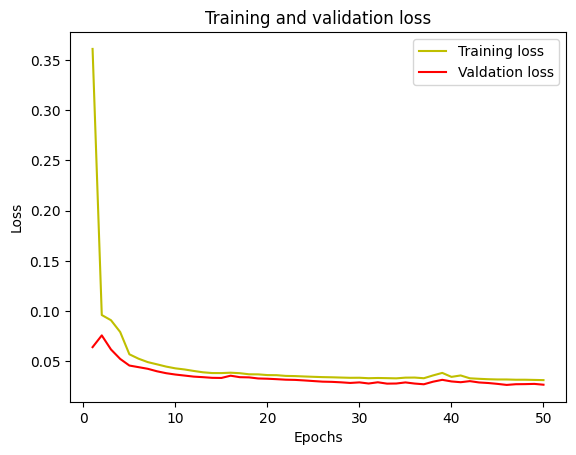

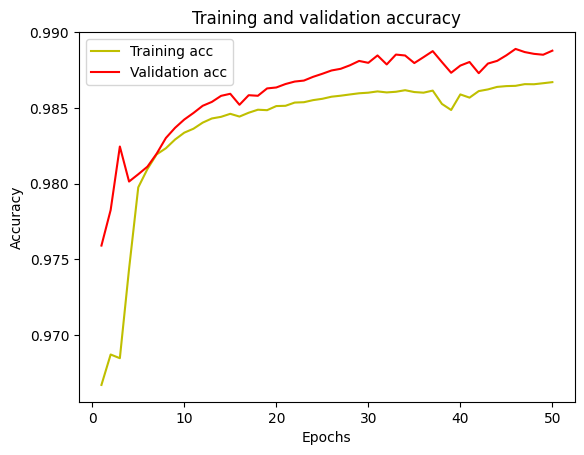

In [25]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "y", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Valdation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "y", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
# Calculate IOU for each class
num_classes = 3
ious = []
y_pred = model.predict(X_test)
for class_idx in range(num_classes):
    y_pred_class = y_pred[..., class_idx] > 0.1  # this value is a probability cutoff
    y_test_class = y_test[..., class_idx]

    intersection = np.logical_and(y_test_class, y_pred_class)
    union = np.logical_or(y_test_class, y_pred_class)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append(iou_score)

# Calculate mean IOU
mean_iou = np.mean(ious)
print(f"Mean IoU score: {mean_iou}")
print(f"IoU Scores: {ious}")

1/1 [==============================] - 0s 192ms/step
Mean IoU score: 0.5947237407314651
IoU Scores: [0.9920183117310595, 0.2727553721895956, 0.5193975382737399]


In [27]:
model.input_shape

(None, 1024, 1024, 2)

In [ ]:
# Load other model for comparison
path_to_model = MODEL_SAVE_DIR / "20230817_10-26-23_cats_512_b4_e50_hessian_upper_4_0.hdf5"
print(path_to_model)
other_model = tf.keras.models.load_model(path_to_model)

In [ ]:
# Manually grabbed 1024x1024 test image
test_image_original = original_image_dataset[1]
plt.imshow(test_image_original)
plt.show()
print(test_image_original.shape)
test_image_ridges = image_dataset[1]
plt.imshow(test_image_ridges)
plt.show()

test_image = np.zeros((1024, 1024, 2))
test_image[:, :, 1] = test_image_original
test_image[:, :, 0] = test_image_ridges

ground_truth = mask_dataset[1]
plt.imshow(ground_truth)
plt.show()

test image number: 4 / 4
shape: (1, 1024, 1024, 2) min: 0.0 max: 1.0
dtype: float64
1/1 [==============================] - 0s 19ms/step


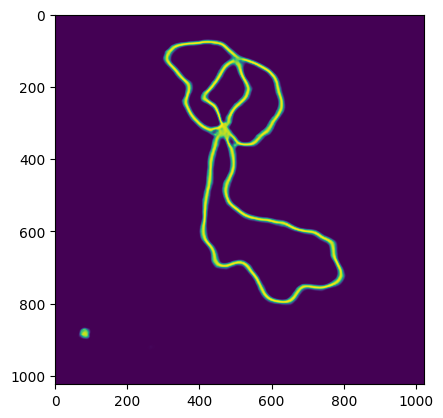

<Axes: >

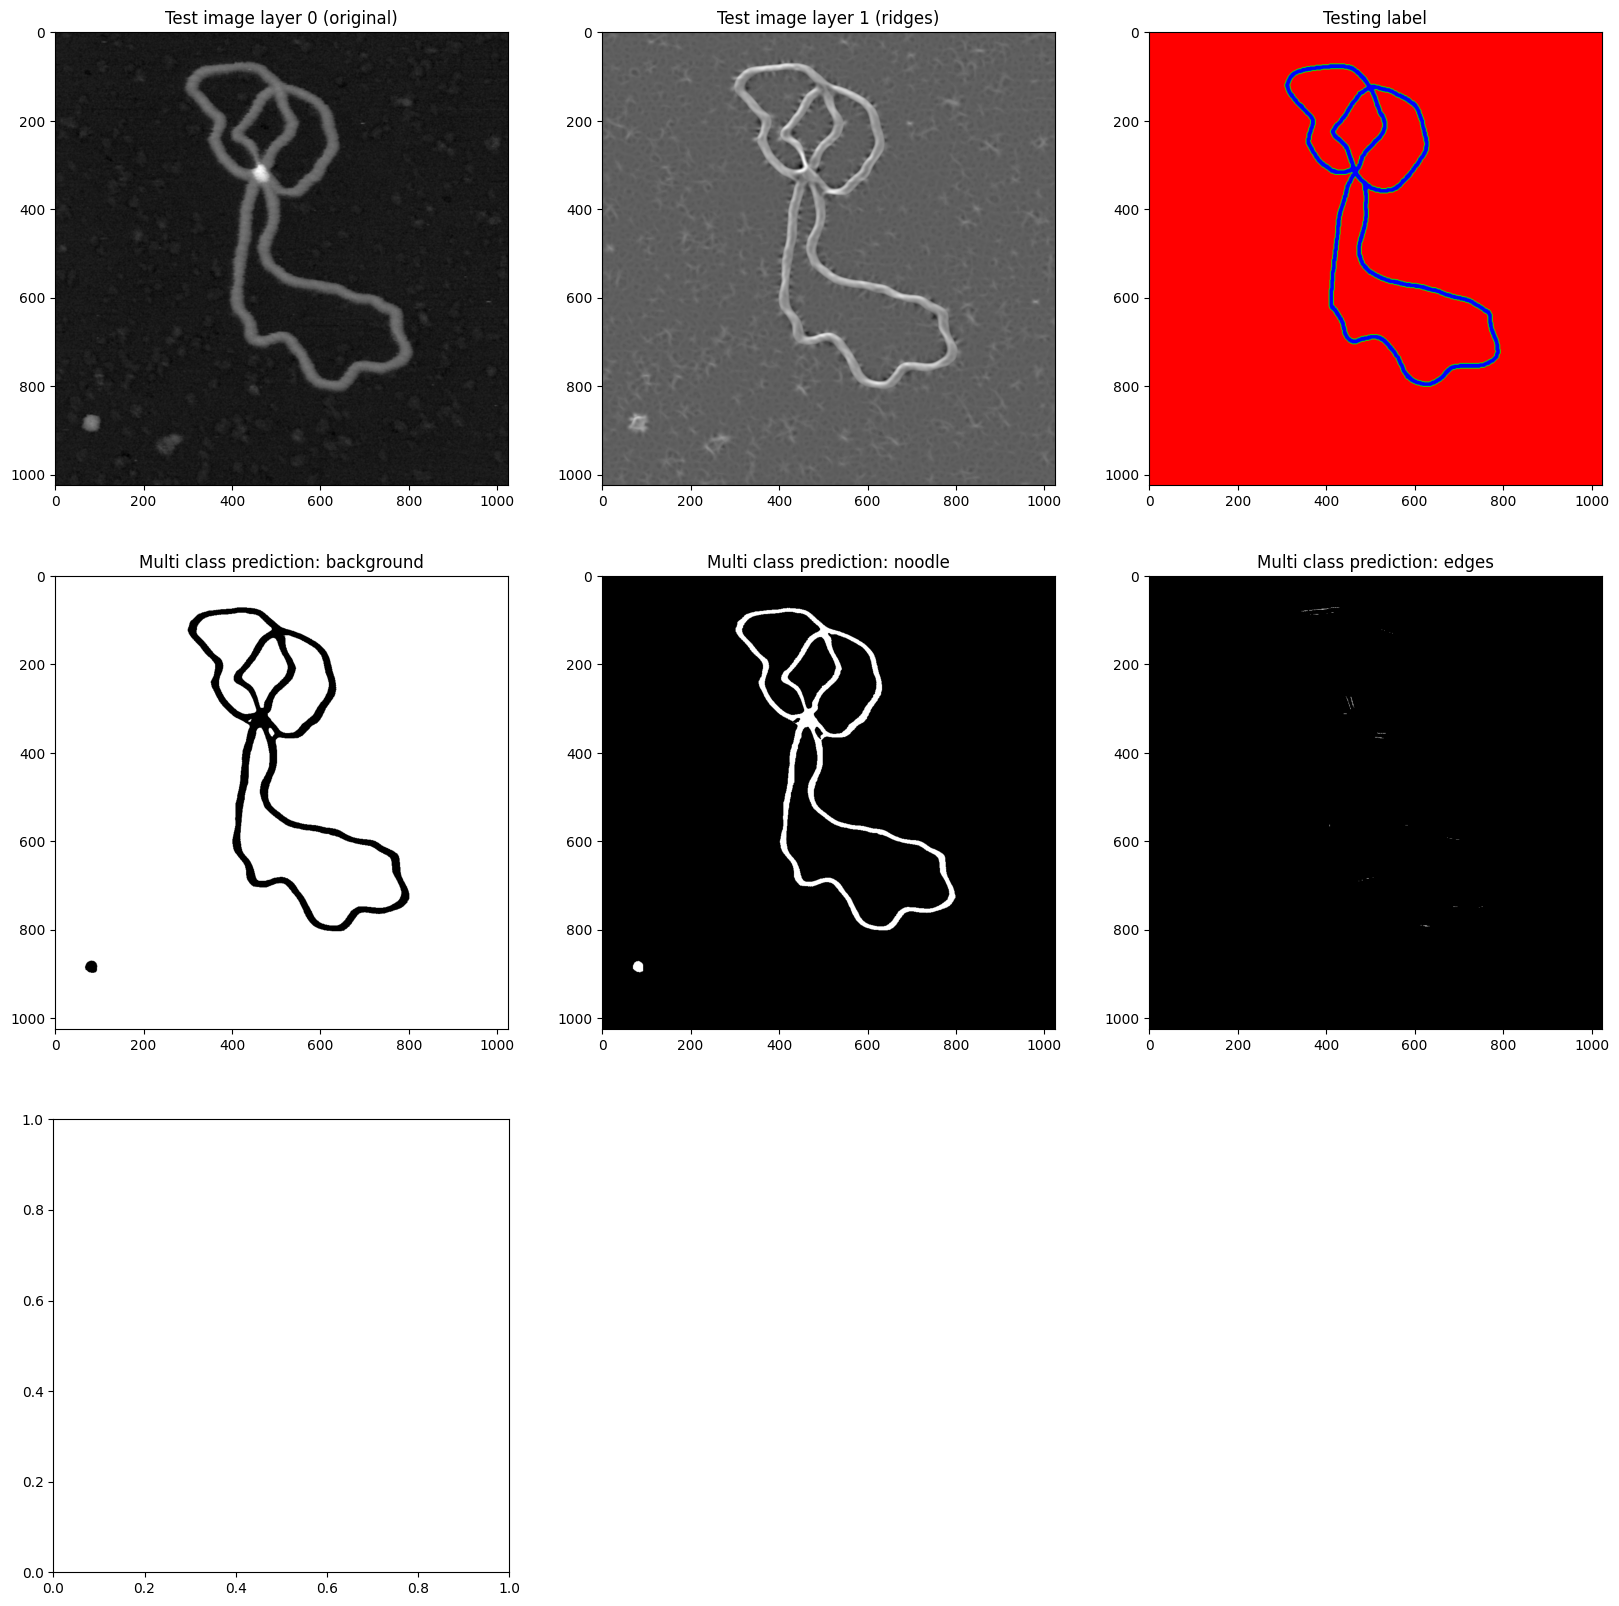

In [42]:
# See how it predicts our testing dataset

threshold = 0.5

# test_img_number = random.randint(0, len(X_test) - 1)
test_img_number = 4

# print(f"test image number: {test_img_number} / {len(X_test)}")
# test_img = X_test[test_img_number, :, :, :]
# print(f"test image number: {test_img_number} / {len(X_train)}")
# test_img = X_train[test_img_number, :, :, :]
# test_img = np.expand_dims(test_img, axis=0)
# print(test_img.shape)


# ground_truth = y_test[test_img_number, :, :, 0]
# ground_truth = y_train[test_img_number, :, :, 0]

# For 1024 test
# test_img = np.expand_dims(test_image, axis=0)
# ground_truth = ground_truth

# For 1024 trained model
print(f"test image number: {test_img_number} / {len(X_test)-1}")
test_img = X_test[test_img_number, :, :, :]
test_img = np.expand_dims(test_img, axis=0)
ground_truth = y_test[test_img_number, :, :, :]

# ground_truth = ground_truth.reshape(512, 512)
print(f"shape: {test_img.shape} min: {np.min(test_img)} max: {np.max(test_img)}")
print(f"dtype: {test_img.dtype}")
prediction = model.predict(test_img)

plt.imshow(prediction[0, :, :, 2])
plt.show()

prediction_background = prediction[0, :, :, 0]
prediction_background = (prediction_background > threshold).astype(np.uint8)

prediction_edges = prediction[0, :, :, 1]
prediction_edges = (prediction_edges > threshold).astype(np.uint8)

prediction_noodle = prediction[0, :, :, 2]
prediction_noodle = (prediction_noodle > threshold).astype(np.uint8)


# previous_prediction = other_model.predict(test_img[:, :, :, 0])[0, :, :, 0] > threshold

plt.figure(figsize=(20, 20))
plt.subplot(331)
plt.imshow(test_img[0, :, :, 1], cmap="gray")
plt.title("Test image layer 0 (original)")
plt.subplot(332)
plt.title("Test image layer 1 (ridges)")
plt.imshow(test_img[0, :, :, 0], cmap="gray")
plt.subplot(333)
plt.imshow(ground_truth, cmap="gray")
plt.title("Testing label")
plt.subplot(334)
plt.imshow(prediction_background, cmap="gray")
plt.title("Multi class prediction: background")
plt.subplot(335)
plt.imshow(prediction_noodle, cmap="gray")
plt.title("Multi class prediction: noodle")
plt.subplot(336)
plt.imshow(prediction_edges, cmap="gray")
plt.title("Multi class prediction: edges")
plt.subplot(337)
# plt.imshow(previous_prediction, cmap="gray")
# plt.title("Single channel (previous) model prediction")
# plt.show()

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(test_img)
# ax.imshow(np.ma.masked_where(prediction == 0, prediction))
# plt.show()

# prediction = prediction == 0
# print(f"prediction shape: {prediction.shape}")
# difference = ground_truth.astype(int) - prediction.astype(int)
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(difference)
# ax.set_title("prediction difference - yellow is prediction, teal is ground truth")
# plt.show()

# labelled = label(prediction)
# coloured = label2rgb(labelled)
# plt.imshow(coloured)

In [ ]:
# Try a completely new image

# FROM PNG
# another_image_file = './dl_data/to_be_labelled/20230207_MeO_perov_10um.0_00001.png'
# another_image_file = str(
#     Path(
#         "/Users/sylvi/topo_data/textured-silicon/flattened_images/tapp_ref_perovskite_si_fraunhofer_5um.0_00000_sylvia_freq_split_1DFFT_filter.png"
#     )
# )

image_number = random.randint(0, 20)
print(f"image number: {image_number}")
another_image_file = str(
    Path(
        f"/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_all_sigma_4/training_image_{image_number}.png"
    )
    # Path(f"/Users/sylvi/topo_data/cats/toms_low_res/ridges/ridges_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/eddie-haribo/on-target/ridges/ridges_{image_number}.png")
)

original_image_file = str(
    Path(f"/Users/sylvi/topo_data/cats/training_data/images_flattened_all/training_image_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/toms_low_res/flattened/flattened_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/eddie-haribo/on-target/flattened/flattened_{image_number}.png")
)

image = cv2.imread(another_image_file, 0)
print(f"original shape: {np.sqrt(image.size)}")

original_image = cv2.imread(original_image_file, 0)

threshold = 0.1

plt.imshow(image)
plt.show()
# FROM SPM
# another_image_file = Path('/home/sylvia/Desktop/unseen_data/spm_images/20230512-Me41-100NPBSpin-512-5um.0_00000.spm')
# another_image_file = Path('/Users/sylvi/topo_data/perovskite/perovskite_images/Me/20230512-Me41-100NPBSpin-512-5um.0_00000.spm')
# another_image_file = Path('/Users/sylvi/topo_data/perovskite/perovskite_images/AR/AR123_926F_FACsPbI3_evap_5um.0_00002.spm')
# another_image_file = Path('/Users/sylvi/topo_data/perovskite/perovskite_images/AR/AR115_25_BA_MAPbI3_10um.ibw')

# loadscan = io.LoadScans(img_paths = [another_image_file], channel='HeightRetrace')
# loadscan = io.LoadScans(img_paths = [another_image_file], channel='Height')
# loadscan.get_data()
# image, pixel_to_nm = loadscan.load_ibw()
# image, pixel_to_nm = loadscan.load_spm()

# image = perov_flatten.flatten_image(image, order=3, plot_steps=True)

# ====== Loading PNG images =========
# another_image_file = Path("/Users/sylvi/topo_data/textured-silicon/flattened_images/tapp_ref_perovskite_si_fraunhofer_5um.0_00000_sylvia_freq_split_1DFFT_filter.png")
# another_image_file = cv2.imread(str(image), cv2.IMREAD_GRAYSCALE)
# ===================================

# image = detect_ridges(image, sigma=1.0)

# Normalize image
# sns.kdeplot(image.flatten())
# plt.show()
# print(f"min: {np.min(image)} max: {np.max(image)}")
image = image - np.min(image)
image = image / np.max(image)
# image = image - np.min(image)
# print(f'min: {np.min(image)} max: {np.max(image)}')
# image = normalize(image)
# image = image / np.max(image)
# print(f"min: {np.min(image)} max: {np.max(image)}")
# sns.kdeplot(image.flatten())
# plt.show()

# Resize image to the correct size
# print(f"image shape: {image.shape}")
# print(f"min, max values: {np.min(image), np.max(image)}")
# print(np.unique(image))
# image = Image.fromarray(image)
# image = image.resize((SIZE, SIZE))
# image = np.array(image)
# print(f"image shape: {image.shape}")

# # Get the input image into the right form (since training was in A x 512 x 512 x 1 shape)
# # This was just trial and error, I don't really have a good understanding of this bit
# to_predict = [image]
# to_predict = np.array(to_predict)
# print(f"to predict shape: {to_predict.shape}")
# to_predict = np.expand_dims(to_predict, 3)
# print(f"to predict shape: {to_predict.shape}")
# # Fetch image from the strange array
# test_img = to_predict[0]
# test_img = test_img[:, :, 0][:, :, None]
# test_img = np.expand_dims(test_img, 0)
# print(f"to predict shape: {test_img.shape}")


def predict_unet(image: np.ndarray, confidence: float, model_image_size: int) -> np.ndarray:
    """"""

    # Get the image into the correct format for prediction
    # Resize image
    image = Image.fromarray(image)
    image = image.resize((model_image_size, model_image_size))
    image = np.array(image)
    print(f"image shape: {image.shape}")
    image = [image]
    # print(f"image shape: {image.shape}")
    image = np.array(image)
    print(f"image shape: {image.shape}")
    image = np.expand_dims(image, 3)
    print(f"image shape: {image.shape}")
    image = image[0]
    print(f"image shape: {image.shape}")
    image = image[:, :, 0][:, :, None]
    print(f"image shape: {image.shape}")
    image = np.expand_dims(image, 0)

    return (model.predict(image)[0, :, :, 0] > confidence).astype(np.uint8)


# Get prediction
# prediction = (model.predict(test_img)[0, :, :, 0] > threshold).astype(np.uint8)
prediction = predict_unet(image=image, confidence=threshold, model_image_size=512)

# print(f"prediction unique vals: {np.unique(prediction)}")
# prediction = skeletonize(prediction)
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[1].imshow(image)
ax[1].set_title("ridges")
ax[0].imshow(original_image)
ax[0].set_title("original image")
ax[2].imshow(prediction)
ax[2].set_title("prediction")
fig.suptitle(f"strictness: {threshold}")
fig.tight_layout()


# # Pot prediction
# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(image)
# masked = np.ma.masked_where(prediction.astype(int) == 0, prediction)
# ax.imshow(masked)
# ax.set_title("prediction")
# plt.show()

# labelled = label(prediction == 0, connectivity=1)
# coloured = label2rgb(labelled)
# fig, ax = plt.subplots()
# ax.imshow(coloured)
# plt.show()

# fig, ax = plt.subplots(figsize=(14, 14))
# test_mask = np.zeros(image.shape)
# for j in range(coloured.shape[0]):
#     for i in range(coloured.shape[1]):
#         if np.array_equal(coloured[j, i], np.array([0, 0, 0])):
#             test_mask[j, i] = 1


# overlay = np.zeros(image.shape)

# test_masked = np.ma.masked_where(test_mask == 1, overlay)
# ax.imshow(image)
# ax.imshow(test_masked, alpha=0.1, cmap="binary")
# ax.set_title("overlay")
# plt.show()

# # Plot skeletonised segmentation
# skeleton_prediction = skeletonize(prediction)
# print(f"unique skeleton prediction: {np.unique(skeleton_prediction)}")
# plt.imshow(skeleton_prediction)
# plt.show()

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.imshow(image)
# ax.set_title("flattened image")
# plt.show()

In [ ]:
image_number = random.randint(0, 20)
print(f"image number: {image_number}")
another_image_file = str(
    Path(
        f"/Users/sylvi/topo_data/cats/training_data/images_edge_detection_upper_all_sigma_4/training_image_{image_number}.png"
    )
    # Path(f"/Users/sylvi/topo_data/cats/toms_low_res/ridges/ridges_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/eddie-haribo/on-target/ridges/ridges_{image_number}.png")
)

original_image_file = str(
    Path(f"/Users/sylvi/topo_data/cats/training_data/images_flattened_all/training_image_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/toms_low_res/flattened/flattened_{image_number}.png")
    # Path(f"/Users/sylvi/topo_data/cats/eddie-haribo/on-target/flattened/flattened_{image_number}.png")
)

image = cv2.imread(another_image_file, 0)
print(f"original shape: {np.sqrt(image.size)}")

original_image = cv2.imread(original_image_file, 0)

original_image = original_image - np.min(original_image)
original_image = original_image / np.max(original_image)

ridges = detect_ridges(original_image, sigma=4.0)
plt.imshow(ridges, cmap="viridis")
plt.colorbar()
plt.show()

# predicted = grain_finding_cats_unet.predict_unet(
#     image=original_image, confidence=0.1, model_image_size=512, image_output_dir=Path("./"), filename="test-image"
# )